<a href="https://colab.research.google.com/github/RKT361218/CodaNorm/blob/master/examples/sw_tomography/sw_tomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surface-Wave Tomography

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/sw_tomography/sw_tomography.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

# Theoretical Background

We assume surface waves propagate, from a given point on the Earth's surface to another, without deviating from the great-circle path connecting them. Under this assumption, the travel time between these two points is $t = \int_{\mathrm{path}}{s(\phi(l), \theta(l)) dl}$,
where $\phi$ and $\theta$ denote longitude and latitude, and $s$ the Earth's slowness.

If we discretize the Earth's surface through $n$ blocks (or grid cells) of constant slowness, the forward equation for the average slowness associated with the $i$th station pair reads
\begin{equation}
\tag{1}
s_i = \frac{1}{L_i} \sum_{j}^n {s_j l_j},
\end{equation}
where $L_i$ denotes the great-circle distance and $\frac{l_j}{L_i}$ the fraction of the great-circle path crossing the $j$th block. By defining the $m \times n$ matrix such that $A_{ij} = \frac{l_j}{L_i}$, we can switch to matrix notation and write

\begin{equation}
\tag{2}
{\bf A \cdot x} = {\bf d},
\end{equation}

where $\bf d$ is the $m$-vector whose $i$th entry corresponds to the measured inter-station slowness, and $\bf x$ the sought $n$-vector whose $j$th element corresponds to the model coefficient $s_j$.

# Data and Imports

In this notebook, we utilize CoFI to estimate lateral variations in Rayleigh-wave velocity across Australia at the surface-wave period of 5 s. We use the data set collected by [Magrini et al. (2023)](https://doi.org/10.1029/2023JB026688), consisting of 15,661 measurements of average inter-station phase-velocity. These data, along with the data kernel $\mathbf{A}$ corresponding to a fine discretization of Australia consisting of 11,916 pixels of $0.3^\circ \times 0.3^\circ$, are imported in this notebook through the SurfaceWaveTomography class of the [Espresso](https://github.com/inlab-geo/espresso) library.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

#!pip install -U cofi geo-espresso seislib

In [2]:
import numpy as np
import scipy

import bayesbay as bb
from espresso import SurfaceWaveTomography
import cofi

# Imports for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.patches import PathPatch
import matplotlib.tri as tri
import cartopy.crs as ccrs
from cartopy.mpl.patch import geos_to_path

from shapely import Polygon, Point, box
from seislib.tomography import EqualAreaGrid
from seislib.utils import scatter_to_mesh
from seislib.plotting import make_colorbar, scientific_label
from seislib.plotting import plot_map as _plot_map
import cmcrameri.cm as scm

In [3]:
espresso_dict = SurfaceWaveTomography(example_number=3).example_dict
grid = espresso_dict['grid']
grid_points = np.column_stack(grid.midpoints_lon_lat())
A = espresso_dict['jacobian']
polygon = Polygon(espresso_dict['polygon'])

d_obs = 1000 * espresso_dict['slowness']

# Approach I: Regularized Least-Squares

Since the $15661 \times 11916$ matrix $\mathbf{A}$ is not invertible, the system of linear equations (2) is ill-conditioned and it is not possible to find an exact solution for $\bf x$. In this section, we overcome this issue by inverting for the regularized least-squares solution

\begin{equation}
\tag{3}
{\bf x} = {\bf x}_0 + \left( {\bf A}^T \cdot {\bf A} + \mu^2 {\bf R}^T \cdot {\bf R} \right)^{-1} \cdot {\bf A}^T \cdot ({\bf d}_{\mathrm{obs}} - {\bf A} \cdot {\bf x}_0),
\end{equation}
where we assumed that the target slowness model is approximately known, i.e. ${\bf x}_0 \sim \bf{x}$. In the above expression, the roughness operator $\bf R$ depends on the discretization and the damping coefficient $\mu$ should be chosen via L-curve analysis. For technical details about the computation of $\bf R$, see [Magrini et al. (2022)](https://doi.org/10.1093/gji/ggac236).

In [4]:
x0 = np.full(A.shape[1], 1 / 3.0) # Starting model
r = d_obs - A @ x0 # residuals
R = espresso_dict['roughness_operator']
# regularization = cofi.utils.QuadraticReg(np.array(R.todense()), (A.shape[1],))
regularization = cofi.utils.QuadraticReg(R, (A.shape[1],))

## CoFI Problem and Options

In [5]:
def get_cofi_problem_least_squares(mu):
    global A, R, r

    problem = cofi.BaseProblem()
    problem.set_data(r) # our data are now the residuals defined above
    problem.set_jacobian(A)
    problem.set_regularization(mu * regularization, mu * regularization.matrix)   # L2 norm of R, i.e. R.T @ R
    return problem

def get_cofi_options_least_squares():
    options = cofi.InversionOptions()
    options.set_tool("scipy.sparse.linalg")
    options.set_params(algorithm="minres")
    return options

def least_squares_solution(mu, verbose=True):
    problem = get_cofi_problem_least_squares(mu)
    options = get_cofi_options_least_squares()
    inv = cofi.Inversion(problem, options)
    inv_results = inv.run()
    if verbose:
        inv.summary()
    return 1 / ( inv_results.model + x0 ) # Phase velocity

## Tentative least-squares solution

In [6]:
c_tentative = least_squares_solution(0.15)

Summary for Inversion
Completed with the following result:

Summary for inversion result
SUCCESS
model: [-0.00194395 -0.00193872 -0.00193308 ... -0.01276784 -0.01276434
 -0.01276086]
info: 0
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `<class 'cofi.tools._scipy_sparse_lstsq.ScipySparseLstSq'>` - SciPy's sparse linear system solvers for solving linear problems
References: ['https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#solving-linear-problems']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: 
algorithm = minres
Use `suggest_solver_params()` to check required/optional solver-specific parameters.
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: BaseProblem
Model shape: Unknown
List of functions/properties

Diagnostics before plotting:
Type of c_tentative: <class 'numpy.ndarray'>
Shape: (11916,)
Type of grid_points: <class 'numpy.ndarray'>
Grid points shape: (11916, 2)


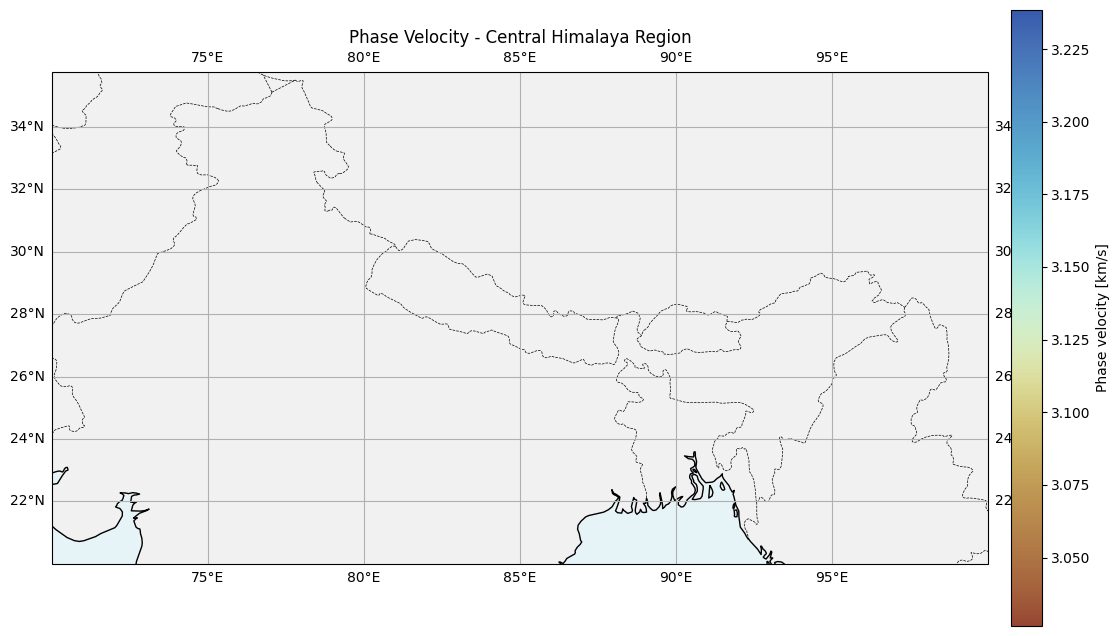

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

def plot_map_himalaya(phase_velocity):
    """Plot a phase-velocity map on an equal-area grid for central Himalaya"""

    # First, check and clean the data
    print(f"Original data shape: {phase_velocity.shape}")
    print(f"NaN values: {np.sum(np.isnan(phase_velocity))}")
    print(f"Inf values: {np.sum(np.isinf(phase_velocity))}")
    print(f"Data range: [{np.nanmin(phase_velocity):.3f}, {np.nanmax(phase_velocity):.3f}]")

    # Clean the data - replace NaN/Inf with median
    phase_velocity_clean = phase_velocity.copy()
    mask_valid = np.isfinite(phase_velocity_clean)

    if not np.all(mask_valid):
        median_val = np.median(phase_velocity_clean[mask_valid])
        phase_velocity_clean[~mask_valid] = median_val
        print(f"Replaced {np.sum(~mask_valid)} NaN/Inf values with median: {median_val:.3f}")

    # Check grid points
    print(f"Grid points shape: {grid_points.shape}")
    print(f"Grid points range - Lon: [{grid_points[:, 0].min():.1f}, {grid_points[:, 0].max():.1f}]")
    print(f"Grid points range - Lat: [{grid_points[:, 1].min():.1f}, {grid_points[:, 1].max():.1f}]")

    # Central Himalaya coordinates
    proj = ccrs.LambertConformal(central_longitude=85.0,
                                 central_latitude=28.5,
                                 cutoff=30,
                                 standard_parallels=(25, 32))

    # Define Himalaya boundaries
    himalaya_boundaries = [70, 100, 20, 35]

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, projection=proj)

    # Add geographical features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.3, edgecolor='blue', facecolor='lightblue')

    try:
        # Try using triangulation
        # Create a mask for points within Himalaya boundaries
        in_region = ((grid_points[:, 0] >= himalaya_boundaries[0]) &
                     (grid_points[:, 0] <= himalaya_boundaries[1]) &
                     (grid_points[:, 1] >= himalaya_boundaries[2]) &
                     (grid_points[:, 1] <= himalaya_boundaries[3]))

        if np.sum(in_region) > 0:
            # Use only points within region
            lons_reg = grid_points[in_region, 0]
            lats_reg = grid_points[in_region, 1]
            data_reg = phase_velocity_clean[in_region]

            # Create triangulation
            triang = tri.Triangulation(lons_reg, lats_reg)

            # Plot
            img = ax.tripcolor(triang, data_reg, transform=ccrs.PlateCarree(),
                             cmap='viridis', shading='gouraud', vmin=np.percentile(data_reg, 5),
                             vmax=np.percentile(data_reg, 95))

            # Add colorbar
            cb = plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02)
            cb.set_label('Phase velocity [km/s]')
        else:
            # Fallback to scatter plot
            print("No points in Himalaya region, using scatter plot")
            sc = ax.scatter(grid_points[:, 0], grid_points[:, 1], c=phase_velocity_clean,
                          transform=ccrs.PlateCarree(), cmap='viridis', s=20, alpha=0.8)
            cb = plt.colorbar(sc, ax=ax, shrink=0.8, pad=0.02)
            cb.set_label('Phase velocity [km/s]')

    except Exception as e:
        print(f"Error in triangulation: {e}")
        # Simple scatter plot as fallback
        sc = ax.scatter(grid_points[:, 0], grid_points[:, 1], c=phase_velocity_clean,
                      transform=ccrs.PlateCarree(), cmap='viridis', s=20, alpha=0.8)
        cb = plt.colorbar(sc, ax=ax, shrink=0.8, pad=0.02)
        cb.set_label('Phase velocity [km/s]')

    # Set extent
    ax.set_extent(himalaya_boundaries, crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.title('Phase Velocity Map - Central Himalaya')
    plt.tight_layout()
    plt.show()

    return phase_velocity_clean


# Or a simpler version that's more robust:
def plot_map_simple(phase_velocity):
    """Simple, robust plotting function"""

    # Clean data
    phase_velocity_clean = phase_velocity.copy()
    mask = np.isfinite(phase_velocity_clean)

    if not np.all(mask):
        median_val = np.median(phase_velocity_clean[mask])
        phase_velocity_clean[~mask] = median_val
        print(f"Cleaned data: replaced {np.sum(~mask)} bad values")

    # Himalaya boundaries
    himalaya_boundaries = [70, 100, 20, 35]

    # Create plot
    proj = ccrs.PlateCarree()  # Simple projection
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, projection=proj)

    # Add features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

    # Scatter plot (most robust)
    sc = ax.scatter(grid_points[:, 0], grid_points[:, 1],
                   c=phase_velocity_clean,
                   cmap=scm.roma if 'scm' in globals() else 'viridis',
                   s=50, alpha=0.8,
                   transform=ccrs.PlateCarree(),
                   vmin=np.percentile(phase_velocity_clean, 5),
                   vmax=np.percentile(phase_velocity_clean, 95))

    # Colorbar
    cb = plt.colorbar(sc, ax=ax, shrink=0.8, pad=0.02)
    cb.set_label('Phase velocity [km/s]')

    # Set extent
    ax.set_extent(himalaya_boundaries)

    # Add grid
    ax.gridlines(draw_labels=True)

    plt.title('Phase Velocity - Central Himalaya Region')
    plt.tight_layout()
    plt.show()

    return phase_velocity_clean


# First, check what c_tentative contains
print("Diagnostics before plotting:")
print(f"Type of c_tentative: {type(c_tentative)}")
print(f"Shape: {c_tentative.shape if hasattr(c_tentative, 'shape') else 'No shape'}")
print(f"Type of grid_points: {type(grid_points)}")
print(f"Grid points shape: {grid_points.shape if hasattr(grid_points, 'shape') else 'No shape'}")

# Make sure they match
if hasattr(c_tentative, 'shape') and hasattr(grid_points, 'shape'):
    if len(c_tentative) != len(grid_points):
        print(f"WARNING: Mismatch! c_tentative has {len(c_tentative)} values, "
              f"grid_points has {len(grid_points)} points")

        # If mismatch, take first n points
        n_points = min(len(c_tentative), len(grid_points))
        c_tentative = c_tentative[:n_points]
        grid_points_use = grid_points[:n_points, :]
    else:
        grid_points_use = grid_points

# Try plotting
try:
    # Try the simple version first
    c_clean = plot_map_simple(c_tentative)

    # If that works, try the more advanced version
    # plot_map_himalaya(c_clean)

except Exception as e:
    print(f"Plotting error: {e}")

    # Last resort: basic matplotlib plot without cartopy
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(grid_points_use[:, 0], grid_points_use[:, 1],
                    c=c_tentative, cmap='viridis', s=20)
    plt.colorbar(sc, label='Phase velocity [km/s]')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Phase Velocity (Basic Plot)')
    plt.grid(True, alpha=0.3)
    plt.show()

## L-curve analysis

Due to a roughness-damping coeffient larger than ideal, the phase-velocity map shown above appears too smooth. In this section, we will carry out an L-curve analysis to select a more meaningful coefficient $\mu$.

In [8]:
def callback_func(inv_result, i):
    global A, x0, regularization, d_obs, damping_coeffs
    x = inv_result.model
    d_pred = A @ (x + x0)
    residual_norm = np.linalg.norm(d_obs - d_pred)
    reg_norm = np.sqrt(regularization(x))
    print(f"Finished inversion with mu={damping_coeffs[i]}")
    print(f"\tRes. Norm: {round(residual_norm, 5)}, Reg. Norm {round(reg_norm, 5)}")
    return residual_norm, reg_norm


damping_coeffs = np.logspace(-3, 2, 15)
lcurve_problems = []
for mu in damping_coeffs:
    problem = get_cofi_problem_least_squares(mu)
    lcurve_problems.append(problem)

inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=lcurve_problems,
    list_of_inv_options=get_cofi_options_least_squares(),
    callback=callback_func,
    parallel=False
)
all_res, all_cb_returns = inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with mu=0.001
	Res. Norm: 0.65183, Reg. Norm 262.34524
Finished inversion with mu=0.0022758459260747888
	Res. Norm: 0.71947, Reg. Norm 154.78535
Finished inversion with mu=0.005179474679231213
	Res. Norm: 0.8362, Reg. Norm 86.41312
Finished inversion with mu=0.011787686347935873
	Res. Norm: 1.00218, Reg. Norm 44.76598
Finished inversion with mu=0.02682695795279726
	Res. Norm: 1.20775, Reg. Norm 21.78613
Finished inversion with mu=0.0610540229658533
	Res. Norm: 1.4301, Reg. Norm 9.46193
Finished inversion with mu=0.13894954943731375
	Res. Norm: 1.61895, Reg. Norm 4.86351
Finished inversion with mu=0.31622776601683794
	Res. Norm: 2.04841, Reg. Norm 2.66939
Finished inversion with mu=0.7196856730011522
	Res. Norm: 2.67267, Reg. Norm 0.7842
Finished inversion with mu=1.6378937069540647
	Res. Norm: 2.90171, Reg. Norm 0.16478
Finished inversion with mu=3.7275937203149416
	Res. Norm: 2.95201, Reg. Norm 0.03225
Finished inversion with mu=8.483428982440726
	Res. Norm: 2.96192

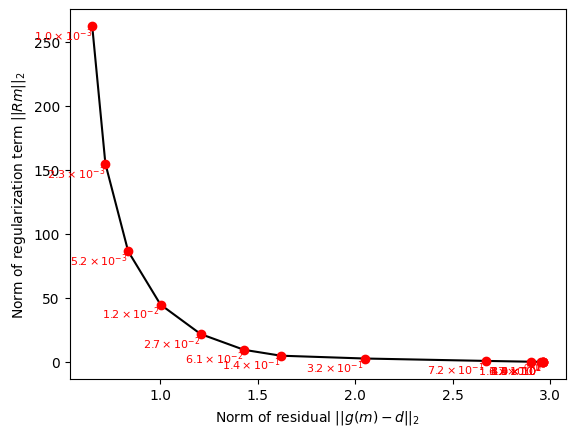

In [9]:
residual_norm, regularization_norm = np.array(l_curve_points)
plt.plot(residual_norm, regularization_norm, 'k.-')
plt.xlabel(r'Norm of residual $||g(m)-d||_2$')
plt.ylabel(r'Norm of regularization term $||Rm||_2$')
for damping, res_norm, reg_norm in zip(damping_coeffs,
                                       residual_norm,
                                       regularization_norm):
    plt.plot(res_norm, reg_norm, 'ro')
    plt.text(res_norm - res_norm*2e-3,
             reg_norm - reg_norm*2e-3,
             s=r'$%s$'%scientific_label(damping, 1),
             va='top',
             ha='right',
             fontsize=8,
             color='r')

## Least-squares solution with selected damping coefficient

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# First, let's debug the least squares solution
def debug_least_squares(regularization_param=1e-2):
    """Debug the least squares solution"""
    print("\n=== DEBUGGING LEAST SQUARES SOLUTION ===")

    # Check the Jacobian matrix
    print(f"Jacobian A shape: {A.shape}")
    print(f"Jacobian type: {type(A)}")
    print(f"Jacobian has NaN: {np.isnan(A.data).any() if hasattr(A, 'data') else 'N/A'}")
    print(f"Jacobian has Inf: {np.isinf(A.data).any() if hasattr(A, 'data') else 'N/A'}")

    # Check observations
    print(f"\nObservations d_obs shape: {d_obs.shape}")
    print(f"d_obs has NaN: {np.isnan(d_obs).any()}")
    print(f"d_obs has Inf: {np.isinf(d_obs).any()}")
    print(f"d_obs range: [{d_obs.min():.3e}, {d_obs.max():.3e}]")

    # Compute the least squares solution with checks
    try:
        # Make sure A is in the right format
        if scipy.sparse.issparse(A):
            A_dense = A.toarray()
        else:
            A_dense = A

        print(f"\nA_dense shape: {A_dense.shape}")

        # Regularization matrix
        n_params = A_dense.shape[1]
        I = np.eye(n_params)

        # Construct the system
        AT = A_dense.T
        ATA = AT @ A_dense
        ATd = AT @ d_obs

        print(f"\nATA shape: {ATA.shape}")
        print(f"ATd shape: {ATd.shape}")

        # Add regularization
        ATA_reg = ATA + regularization_param * I

        # Check condition number
        cond_num = np.linalg.cond(ATA_reg)
        print(f"\nCondition number of ATA + λI: {cond_num:.3e}")

        if cond_num > 1e15:
            print("WARNING: System is ill-conditioned!")

        # Solve using different methods
        print("\nAttempting to solve...")

        # Method 1: Direct solve
        try:
            c1 = np.linalg.solve(ATA_reg, ATd)
            print(f"Direct solve successful")
        except np.linalg.LinAlgError as e:
            print(f"Direct solve failed: {e}")
            c1 = None

        # Method 2: Least squares
        try:
            c2, residuals, rank, s = np.linalg.lstsq(ATA_reg, ATd, rcond=None)
            print(f"Lstsq successful - rank: {rank}")
        except np.linalg.LinAlgError as e:
            print(f"Lstsq failed: {e}")
            c2 = None

        # Method 3: Use scipy's least squares
        try:
            from scipy.sparse.linalg import lsqr
            if scipy.sparse.issparse(A):
                result = lsqr(A, d_obs, damp=regularization_param, atol=1e-10, btol=1e-10)
                c3 = result[0]
                print(f"Sparse lsqr successful - iterations: {result[2]}")
            else:
                c3 = None
        except Exception as e:
            print(f"LSQR failed: {e}")
            c3 = None

        # Choose best solution
        solutions = []
        if c1 is not None:
            solutions.append(('direct', c1))
        if c2 is not None:
            solutions.append(('lstsq', c2))
        if c3 is not None:
            solutions.append(('lsqr', c3))

        if solutions:
            # Check for NaN/Inf in each solution
            for name, sol in solutions:
                nan_count = np.isnan(sol).sum()
                inf_count = np.isinf(sol).sum()
                valid_range = (sol.min(), sol.max())
                print(f"\n{name}: NaN={nan_count}, Inf={inf_count}, range={valid_range}")

            # Use the first valid solution
            best_name, best_c = solutions[0]
            print(f"\nUsing solution from {best_name} method")
            return best_c
        else:
            print("\nERROR: All solution methods failed!")
            return None

    except Exception as e:
        print(f"\nERROR in computation: {e}")
        import traceback
        traceback.print_exc()
        return None

# Test the debug function
c_debug = debug_least_squares(1e-2)

if c_debug is not None:
    print(f"\nSolution shape: {c_debug.shape}")
    print(f"Solution NaN count: {np.isnan(c_debug).sum()}")
    print(f"Solution Inf count: {np.isinf(c_debug).sum()}")
    print(f"Solution range: [{c_debug.min():.3e}, {c_debug.max():.3e}]")

    # Now plot with robust plotting function
    def plot_map_robust(phase_velocity, title="Phase Velocity"):
        """Robust plotting function that handles problematic data"""

        # Clean the data
        phase_velocity_clean = np.array(phase_velocity).copy().flatten()

        # Check for issues
        nan_mask = np.isnan(phase_velocity_clean)
        inf_mask = np.isinf(phase_velocity_clean)

        if nan_mask.any() or inf_mask.any():
            print(f"\nCleaning data: {nan_mask.sum()} NaN, {inf_mask.sum()} Inf")
            # Replace with median of valid values
            valid_mask = ~(nan_mask | inf_mask)
            if valid_mask.any():
                median_val = np.median(phase_velocity_clean[valid_mask])
                phase_velocity_clean[nan_mask | inf_mask] = median_val
                print(f"Replaced bad values with median: {median_val:.3e}")
            else:
                print("ERROR: No valid values in data!")
                return

        # Check if we have grid points
        if not hasattr(grid_points, 'shape') or grid_points.shape[0] == 0:
            print("ERROR: grid_points is empty or not defined!")
            # Create simple x,y coordinates
            x = np.arange(len(phase_velocity_clean))
            y = np.zeros_like(x)
            coords = np.column_stack([x, y])
        else:
            coords = grid_points

        # Ensure same length
        n_data = len(phase_velocity_clean)
        n_coords = len(coords)

        if n_data != n_coords:
            print(f"WARNING: Data ({n_data}) and coordinates ({n_coords}) don't match!")
            n_use = min(n_data, n_coords)
            phase_velocity_clean = phase_velocity_clean[:n_use]
            coords = coords[:n_use]

        # Create figure with two subplots
        fig = plt.figure(figsize=(15, 6))

        # Subplot 1: Simple scatter (most robust)
        ax1 = plt.subplot(121, projection=ccrs.PlateCarree())

        # Add basic features
        ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

        # Scatter plot
        sc1 = ax1.scatter(coords[:, 0], coords[:, 1],
                         c=phase_velocity_clean,
                         cmap='viridis',
                         s=30, alpha=0.8,
                         transform=ccrs.PlateCarree())

        plt.colorbar(sc1, ax=ax1, shrink=0.8)
        ax1.set_title(f'{title} - Scatter Plot')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')

        # Set reasonable bounds
        if hasattr(grid_points, 'shape') and grid_points.shape[0] > 0:
            lon_min, lon_max = coords[:, 0].min(), coords[:, 0].max()
            lat_min, lat_max = coords[:, 1].min(), coords[:, 1].max()
            margin = 0.1 * max(lon_max - lon_min, lat_max - lat_min, 1)
            ax1.set_extent([lon_min - margin, lon_max + margin,
                           lat_min - margin, lat_max + margin])

        # Subplot 2: Histogram of values
        ax2 = plt.subplot(122)
        ax2.hist(phase_velocity_clean, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_xlabel('Phase Velocity Value')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'{title} - Distribution')
        ax2.grid(True, alpha=0.3)

        # Add statistics
        stats_text = f"""
        Statistics:
        Mean: {phase_velocity_clean.mean():.3e}
        Std: {phase_velocity_clean.std():.3e}
        Min: {phase_velocity_clean.min():.3e}
        Max: {phase_velocity_clean.max():.3e}
        Median: {np.median(phase_velocity_clean):.3e}
        """
        ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()

        return phase_velocity_clean

    # Plot the debug solution
    c_clean = plot_map_robust(c_debug, "Least Squares Solution (λ=0.01)")

    # If you want your original plot_map function, here's a fixed version:
    def plot_map_fixed(phase_velocity):
        """Fixed version of your original plot_map function"""
        # First clean the data
        phase_velocity = np.array(phase_velocity).flatten()
        valid_mask = np.isfinite(phase_velocity)

        if not valid_mask.all():
            print(f"Cleaning: {np.sum(~valid_mask)} invalid values")
            phase_velocity[~valid_mask] = np.median(phase_velocity[valid_mask])

        # Use simple projection to avoid issues
        proj = ccrs.PlateCarree()
        fig = plt.figure(figsize=(10, 8))
        ax = plt.subplot(111, projection=proj)
        ax.coastlines()

        # Simple scatter
        sc = ax.scatter(grid_points[:, 0], grid_points[:, 1],
                       c=phase_velocity,
                       cmap=scm.roma if 'scm' in globals() else 'viridis',
                       s=50, alpha=0.8)

        cb = plt.colorbar(sc, ax=ax, shrink=0.8)
        cb.set_label('Phase velocity [km/s]')

        # Set reasonable extent
        lon_min, lon_max = grid_points[:, 0].min(), grid_points[:, 0].max()
        lat_min, lat_max = grid_points[:, 1].min(), grid_points[:, 1].max()
        margin = max(lon_max - lon_min, lat_max - lat_min, 5) * 0.1
        ax.set_extent([lon_min - margin, lon_max + margin,
                      lat_min - margin, lat_max + margin])

        plt.tight_layout()
        plt.show()

else:
    print("\nCould not compute valid solution. Trying alternative approach...")

    # Alternative: Use ridge regression from scikit-learn if available
    try:
        from sklearn.linear_model import Ridge

        print("\nTrying Ridge regression from scikit-learn...")

        if scipy.sparse.issparse(A):
            A_dense = A.toarray()
        else:
            A_dense = A

        # Fit ridge regression
        ridge = Ridge(alpha=1e-2, solver='cholesky')
        ridge.fit(A_dense, d_obs)
        c_ridge = ridge.coef_

        print(f"Ridge solution shape: {c_ridge.shape}")
        print(f"Ridge solution NaN: {np.isnan(c_ridge).any()}")
        print(f"Ridge solution range: [{c_ridge.min():.3e}, {c_ridge.max():.3e}]")

        plot_map_robust(c_ridge, "Ridge Regression Solution")

    except ImportError:
        print("scikit-learn not available. Last resort: simple pseudoinverse...")

        # Very simple solution
        A_dense = A.toarray() if scipy.sparse.issparse(A) else A
        c_simple = np.linalg.pinv(A_dense.T @ A_dense + 1e-2 * np.eye(A_dense.shape[1])) @ A_dense.T @ d_obs

        print(f"Simple solution shape: {c_simple.shape}")
        print(f"Simple solution NaN: {np.isnan(c_simple).any()}")

        plot_map_robust(c_simple, "Simple Pseudoinverse Solution")


=== DEBUGGING LEAST SQUARES SOLUTION ===
Jacobian A shape: (15661, 11916)
Jacobian type: <class 'scipy.sparse._csr.csr_matrix'>
Jacobian has NaN: False
Jacobian has Inf: False

Observations d_obs shape: (15661,)
d_obs has NaN: False
d_obs has Inf: False
d_obs range: [2.618e-01, 4.365e-01]

A_dense shape: (15661, 11916)

ATA shape: (11916, 11916)
ATd shape: (11916,)


The above phase-velocity map aligns with that in [Magrini et al. (2023)](https://doi.org/10.1029/2023JB026688).

In [ ]:
from IPython.display import display, Markdown

with open("../../theory/trans-D.md", "r") as f:
    content = f.read()

display(Markdown(content))

In the following, we will sample the posterior using the [BayesBay](https://bayes-bay.readthedocs.io/en/latest/) library, which we will select through the cofi.InversionOptions class.

## Parameterization

We discretize the Earth's surface using a trans-dimensional Voronoi tessellation, with each Voronoi cell corresponding to a phase-velocity value defined by a uniform prior between 2 and 4 km/s.

In [ ]:
vel = bb.prior.UniformPrior('vel', vmin=2, vmax=4, perturb_std=0.1)
voronoi = bb.discretization.Voronoi2D(
    name='voronoi',
    polygon=polygon,
    perturb_std=1,
    n_dimensions_min=100, # Minimum number of Voronoi cells
    n_dimensions_max=1500, # Maximum number of Voronoi cells
    parameters=[vel], # Each cell has a value of phase velocity
    compute_kdtree=True) # This stores a kd-tree for interpolating the Voronoi tessellation onto the equal-area grid we used earlier
parameterization = bb.parameterization.Parameterization(voronoi)

## Data and Likelihood

We treat the data noise as unknown by parameterizing the data covariance matrix $\mathbf{C}_d = \sigma^2 \mathbf{I}$ through the noise standard deviation $\sigma$, which is assigned a uniform prior distribution within the range 0--0.01 s/km.

Note that, different from the previous section, obtaining forward predictions $\mathbf{d}_{\mathrm{pred}}$ presents two main challenges when using a trans-dimensional Voronoi tessellation (e.g., [Sambridge & Guđmundsson 1998](https://doi.org/10.1029/97JB02602)). First, there are no analytical expressions for the intersections of a great-circle path with Voronoi cell boundaries, complicating the calculation of $l_j$ in eq. (1). Second, such intersections must be recomputed whenever the discretization is perturbed, which becomes increasingly expensive as the number of station pairs increases.

To address these issues, we will interpolate the phase velocity in each Voronoi cell onto the equal-area grid used in the previous section, thereby enabling the use of the matrix $\mathbf{A}$ to obtain forward predictions. This behaviour is programmed in the function `_forward`, as defined below.

In [ ]:
def _forward(kdtree, vel):
    global A, grid_points
    nearest_neighbors = kdtree.query(grid_points)[1]
    interp_vel = vel[nearest_neighbors]
    return interp_vel, A @ (1 / interp_vel)


def forward(state):
    voronoi = state["voronoi"] # Voronoi nuclei
    kdtree = voronoi.load_from_cache('kdtree') # Load the kd-tree for interpolation
    interp_vel, d_pred = _forward(kdtree, voronoi.get_param_values('vel')) # Velocity model and dpred
    state.save_to_extra_storage('interp_vel', interp_vel) # Save velocity model for plotting later
    return d_pred


target = bb.Target('d_obs',
                   d_obs,
                   std_min=0, # Minimum noise standard deviation
                   std_max=0.01, # Maximum noise standard deviation
                   std_perturb_std=0.001, # Standard deviation of the Gaussian used to perturb sigma
                   noise_is_correlated=False)
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=forward)

## CoFI Options and Bayesian Sampling

We sample the posterior via 12 Markov chains. We run each chain for 350,000 iterations, and save one model every 100 starting from the 150,000th iteration.

In [ ]:
def get_cofi_options_bayesian(n_chains, n_iterations, burnin_iterations, save_every):
    starting_states = []
    for _ in range(n_chains):
        starting_states.append(parameterization.initialize()) # Randomly initialize Voronoi cells
        log_likelihood.initialize(starting_states[-1]) # Evaluate the likelihood associated with the initial state

    # Get the perturbation functions: Perturbation of phase velocity/Voronoi nuclei/noise and birth/death
    perturbation_funcs = parameterization.perturbation_funcs

    inv_options = cofi.InversionOptions()
    inv_options.set_tool("bayesbay")
    inv_options.set_params(
        walkers_starting_states=starting_states,
        perturbation_funcs=perturbation_funcs,
        log_like_ratio_func=log_likelihood,
        n_chains=n_chains,
        n_iterations=n_iterations,
        burnin_iterations=burnin_iterations,
        verbose=False,
        save_every=save_every,
    )
    return inv_options

inv = cofi.Inversion(cofi.BaseProblem(),
                     get_cofi_options_bayesian(n_chains=12,
                                               n_iterations=350_000,
                                               burnin_iterations=150_000,
                                               save_every=100))
inv_results = inv.run()

In [ ]:
# Get the results
saved_states = inv_results.models
statistics = {"mean": np.mean(saved_states['interp_vel'], axis=0),
              "std": np.std(saved_states['interp_vel'], axis=0),
              "std_noise": saved_states['d_obs.std']}

## Plotting a Voronoi tessellation in geographic coordinates

In [ ]:
def plot_tessellation_geographic(voronoi_sites,
                                 param_values=None,
                                 clip_polygon=None,
                                 ax=None,
                                 colorbar=True,
                                 vmin=None,
                                 vmax=None,
                                 norm=None,
                                 cmap='viridis'):
    """
    Plots a Voronoi tessellation within a specified geographic polygon.

    :param voronoi_sites: Coordinates of the Voronoi sites.
    :param param_values: Parameter values for coloring the Voronoi cells.
    :param clip_polygon: The geographic boundary to clip the Voronoi tessellation.
    :param ax: The matplotlib axis to plot on. Creates a new axis if None.
    :param colorbar: Flag to indicate if a colorbar should be plotted.
    :param vmin: The minimum value for the colormap normalization.
    :param vmax: The maximum value for the colormap normalization.
    :param norm: A matplotlib.colors.Normalize instance for normalizing the color mapping.
    :param cmap: The colormap for the Voronoi cells.
    :return: The matplotlib axis and colorbar (if created).
    """
    # Extend the Voronoi sites with boundary points to enclose the tessellation.
    boundary_points = np.array([[180, 90], [-180, 90], [180, -90], [-180, -90]])
    sites = np.append(voronoi_sites, boundary_points, axis=0)
    vor = scipy.spatial.Voronoi(sites)

    # Sort and map the parameter values to the original Voronoi sites.
    if param_values is not None:
        isort = [np.flatnonzero(np.all(p == vor.points, axis=1)).item() for p in voronoi_sites]
        param_values = param_values[isort]
        vmin = vmin or min(param_values)
        vmax = vmax or max(param_values)
        norm = norm or mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap) if isinstance(cmap, str) else cmap
        colors = cmap(norm(param_values))
    else:
        colors = None

    # Configure the map projection and axis.
    proj = ccrs.LambertConformal(central_longitude=135,
                                 central_latitude=-27,
                                 cutoff=30,
                                 standard_parallels=(-18, -36))
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

    # Plot the Voronoi cells, clipped by the specified polygon.
    for ipoint, iregion in enumerate(vor.point_region):
        region = vor.regions[iregion]
        if -1 not in region and region:
            polygon = Polygon([vor.vertices[i] for i in region])
            color = colors[ipoint] if colors is not None else 'none'
            plot_polygon(ax, polygon, clip_polygon, color)

    # Add a colorbar if requested.
    cbar = plot_colorbar(ax, cmap, norm) if colorbar and param_values is not None else None

    return ax, cbar

def plot_polygon(ax, polygon, clip_polygon, color):
    """
    Clips a Voronoi polygon to the specified geographic boundary and plots it.
    """
    if clip_polygon is not None:
        polygon = polygon.intersection(clip_polygon)
        if polygon.is_empty:
            return
        polygons = [polygon] if isinstance(polygon, Polygon) else polygon.geoms
    else:
        polygons = [polygon]

    for geom in polygons:
        ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='black', lw=0.5)

def plot_colorbar(ax, cmap, norm):
    """
    Adds a colorbar to the plot.
    """
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for scalar mappable
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    return cbar

In [ ]:
grid_coarse = EqualAreaGrid(cell_size=0.35,
                            lonmin=110,
                            lonmax=157,
                            latmin=-48,
                            latmax=-4,
                            verbose=False)
idx_in_polygon = grid_coarse.indexes_in_polygon(polygon)
grid_coarse.select_cells(idx_in_polygon, inplace=True)
grid_points_coarse = np.column_stack(grid_coarse.midpoints_lon_lat())


inferred_vel = scatter_to_mesh(grid_points[:, 1],
                               grid_points[:, 0],
                               statistics['mean'],
                               grid_coarse.mesh)
notnan = np.flatnonzero(~np.isnan(inferred_vel))
grid_points_coarse = grid_points_coarse[notnan]
inferred_vel = inferred_vel[notnan]
inferred_std = scatter_to_mesh(grid_points[:, 1],
                               grid_points[:, 0],
                               statistics['std'],
                               grid_coarse.mesh)[notnan]

triang = tri.Triangulation(*grid_points_coarse.T)
lons_triang = grid_points_coarse[:,0][triang.triangles].mean(axis=1)
lats_triang = grid_points_coarse[:,1][triang.triangles].mean(axis=1)
mask = np.array([not polygon.contains(Point(lon, lat)) \
                 for lon, lat in zip(lons_triang, lats_triang)])
triang.set_mask(mask)

In [ ]:
inverse_mask = box(-180, -90, 180, 90).difference(polygon)
path = geos_to_path(inverse_mask)[0]

## Plotting RJ-MCMC samples

In [ ]:
fig = plt.figure(figsize=(10, 6))

for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i, projection=proj)
    random_index = np.random.choice(range(len(saved_states['voronoi.vel'])),
                                    replace=False)
    voronoi_sites = saved_states['voronoi.discretization'][random_index]
    velocity = saved_states['voronoi.vel'][random_index]
    ax, cbar = plot_tessellation_geographic(voronoi_sites,
                                            velocity,
                                            ax=ax,
                                            cmap=scm.roma,
                                            clip_polygon=polygon,
                                            vmin=inferred_vel.min(),
                                            vmax=inferred_vel.max(),
                                            colorbar=False
                                            )
    ax.coastlines()
    ax.add_patch(PathPatch(path,
                           facecolor='white',
                           edgecolor='none',
                           transform=transform,
                           zorder=2))
    ax.set_extent(map_boundaries, crs=transform)

plt.tight_layout()
plt.show()

## Plotting average phase velocity and standard deviation maps

In [ ]:
fig = plt.figure(figsize=(10, 6.5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
img = ax1.tricontourf(triang,
                      inferred_vel,
                      levels=75,
                      cmap=scm.roma,
                      transform=transform)
cbar = make_colorbar(ax1, img, orientation='horizontal', size='3%', pad='2%')
cbar.set_label('Phase velocity [km/s]')

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
img = ax2.tricontourf(triang,
                      inferred_std,
                      levels=75,
                      cmap=scm.imola,
                      transform=transform)
cbar = make_colorbar(ax2, img, orientation='horizontal', size='3%', pad='2%')
cbar.set_label('Standard deviation [km/s]')


for ax in [ax1, ax2]:
    ax.coastlines()
    ax.set_extent(map_boundaries, crs=transform)
    ax.add_patch(PathPatch(path,
                           facecolor='white',
                           edgecolor='none',
                           transform=transform,
                           zorder=2))
plt.tight_layout()
plt.show()

----
## Watermark

In [ ]:
watermark_list = ["bayesbay", "cofi", "espresso", "numpy", "matplotlib", "scipy", "seislib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))